In [0]:
#https://blog.floydhub.com/a-beginners-guide-on-recurrent-neural-networks-with-pytorch/

import os

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
#!rm data/author_quotes.txt
!mkdir data
!wget -P data https://raw.githubusercontent.com/Samsung-IT-Academy/stepik-dl-nlp/master/datasets/author_quotes.txt
# !ls data

!cat data/author_quotes.txt

In [0]:

with open('data/author_quotes.txt') as input_file:
    author_quotes = input_file.read()[:-1].split('\n')
    author_quotes = [' ' + line for line in author_quotes]


In [0]:
author_quotes[:5]

[' If you live to be a hundred, I want to live to be a hundred minus one day so I never have to live without you.',
 " Promise me you'll always remember: You're braver than you believe, and stronger than you seem, and smarter than you think.",
 ' Did you ever stop to think, and forget to start again?',
 ' Organizing is what you do before you do something, so that when you do it, it is not all mixed up.',
 ' Weeds are flowers too, once you get to know them.']

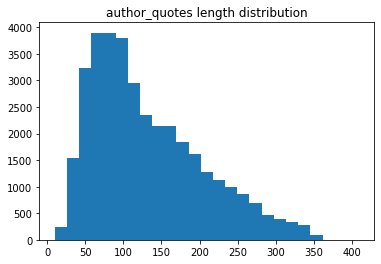

In [0]:


plt.title('author_quotes length distribution')
plt.hist(list(map(len, author_quotes)), bins=25);

In [0]:
#all unique characters go here
tokens = list(set(''.join(author_quotes)))

num_tokens = len(tokens)
print ('num_tokens = ', num_tokens)

num_tokens =  85


In [0]:
#Создадим словарь < символ > -> < id >

token_to_id = {token: idx for idx, token in enumerate(tokens)}

assert len(tokens) == len(token_to_id), "dictionaries must have same size"

for i in range(num_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


In [0]:
def to_matrix(data, token_to_id, max_len=None, dtype='int32', batch_first = True):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, data))
    data_ix = np.zeros([len(data), max_len], dtype) + token_to_id[' ']

    for i in range(len(data)):
        line_ix = [token_to_id[c] for c in data[i]]
        data_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        data_ix = np.transpose(data_ix)

    return data_ix

In [0]:
#Example: cast 4 names to matrices, pad with zeros
print('\n'.join(author_quotes[::2000]))
print(to_matrix(author_quotes[::2000], token_to_id))

#Data prepare

In [9]:
with open('data/author_quotes.txt') as input_file:
    author_quotes = input_file.read()[:-1].split('\n')
    author_quotes = [' ' + line for line in author_quotes]

#all unique characters go here
tokens = list(set(''.join(author_quotes)))

num_tokens = len(tokens)
print ('num_tokens = ', num_tokens)    

#Создадим словарь < символ > -> < id >

token_to_id = {token: idx for idx, token in enumerate(tokens)}

assert len(tokens) == len(token_to_id), "dictionaries must have same size"

for i in range(num_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

def to_matrix(data, token_to_id, max_len=None, dtype='int32', batch_first = True):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, data))
    data_ix = np.zeros([len(data), max_len], dtype) + token_to_id[' ']

    for i in range(len(data)):
        line_ix = [token_to_id[c] for c in data[i]]
        data_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        data_ix = np.transpose(data_ix)

    return data_ix


num_tokens =  85
Seems alright!


#RNN 5

In [0]:
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.num_units = rnn_num_units
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, hidden):
        assert isinstance(x, Variable) and isinstance(x.data, torch.LongTensor)
        h_seq, hidden = self.rnn(self.emb(x), hidden )

        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp, hidden
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return Variable(torch.zeros(batch_size, self.num_units)).unsqueeze(0)    
model = CharRNNLoop(rnn_num_units=256)
opt = torch.optim.Adam(model.parameters())
history = []

# def repackage_hidden(h):
#     """Wraps hidden states in new Variables, to detach them from their history."""
#     if type(h) == Variable:
#         return Variable(h.data)
#     else:
#         return tuple(repackage_hidden(v) for v in h)

##Test train loop

In [0]:
from random import sample
MAX_LENGTH = max(map(len, author_quotes))
batch_size = 32

# the model applies over the whole sequence
batch_ix = to_matrix(sample(author_quotes, batch_size), token_to_id, max_len=MAX_LENGTH)
batch_ix = Variable(torch.LongTensor(batch_ix))

hidden = model.initial_state(batch_size)
# hidden = repackage_hidden(hidden)
logp_seq, hidden = model(batch_ix, hidden)

# compute loss
loss = F.nll_loss(logp_seq[:, 1:].contiguous().view(-1, num_tokens), 
                  batch_ix[:, :-1].contiguous().view(-1))

loss.backward()

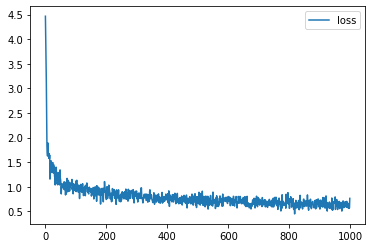

In [75]:
MAX_LENGTH = max(map(len, author_quotes))


for i in range(1000):
    batch_ix = to_matrix(sample(author_quotes, 32), token_to_id, max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    hidden = model.initial_state(batch_size)    
    logp_seq, hidden = model(batch_ix, hidden)
    # hidden.detach_()
    # hidden = hidden.detach()    

    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))
    #print(i, hidden.shape)
    # train with backprop
    loss.backward()

    opt.step()
    opt.zero_grad()
    
    history.append(loss.data.numpy())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:25]) > np.mean(history[-25:]), "RNN didn't converge."

In [76]:
def generate_sample(model, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = model.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = model(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        
        input = x_sequence[:, -1].unsqueeze(0)
        logp_next, hid_state = model(input, hid_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0][0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

for _ in range(10):
    print(generate_sample(model, temperature=.9))

 Wherats to wand my goare ese they art os no car the sos lotl te pentice pott wall that that inlet on out the ringen wapplol of condicas.                                                                                                                                                                                                                                                                                
 I dust, wiople on rytting wore and de to whork must of a allaniespive is thy love geopld be ardibidis chinity.                                                                                                                                                                                                                                                                                                          
 I tonk fords, wo trive it anouthen live in the ncarly and upomoping it, just of gojld can wed te and caterttre kelady peritiens, beten in there and to midar pyserpant counre and w

#RNN 4

In [0]:
import string
import random
import re

all_characters = string.printable
n_characters = len(all_characters)


In [82]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        #self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.gru = nn.RNN(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
      try:
        tensor[c] = all_characters.index(string[c])
      except:
        tensor[c] = all_characters.index(' ')
    return Variable(tensor)

print(char_tensor('abcDEF'))   

def evaluate(prime_str=' ', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def train(inp, target, chunk_len):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0
    for c in range(chunk_len):
      output, hidden = decoder(inp[c], hidden)
      loss += criterion(output, target[c].unsqueeze(0))

    loss.backward()
    decoder_optimizer.step()

    #print(loss.item())
    return loss.item() / chunk_len

def random_training_set(data,chunk_len):    
    chunk = random_chunk(data,chunk_len)
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

def random_chunk(data,chunk_len):
    start_index = random.randint(0, len(data) - chunk_len)
    end_index = start_index + chunk_len + 1
    return data[start_index:end_index]


# def random_chunk(data, chunk_len):
#     start_index = random.randint(0, len(data) - chunk_len)
#     end_index = start_index + chunk_len + 1
#     return data[start_index:end_index]

tensor([10, 11, 12, 39, 40, 41])


In [79]:
with open('data/author_quotes.txt') as input_file:
    data = input_file.read()[:-1].split('\n')
    data = ' '.join(data)


n_epochs = 1000
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 1
chunk_len = 200
lr = 0.005

decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    inp, target = random_training_set(data=data,chunk_len = chunk_len)
    # print(inp, target)
    # print(inp.shape, target.shape)
    loss = train(inp, target, chunk_len=chunk_len)       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate('Wh', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 13s (100 10%) 2.6400]
Wheching ere at arthet e dimer, woof thed. I gowrt tead at ealt Thel sut fare I berking noot totike th 

 26s (200 20%) 2.1445]
Wher aver hore reat the ha farvon hinth hay frolld, the lur've mace of ghead mpet a thaiver oul list t 

 39s (300 30%) 1.9928]
Whe Un you 'rat trith wave is till waryan of the the pecan be are todrane, tsie be you to no when wam  

 52s (400 40%) 2.1181]
Whing be Past dow nlimgoust Hats ist the I winst to got the fay momet youling, wore on a cor bald ti n 

 5s (500 50%) 1.8532]
When you got do is I'm in worens, a wown and of that in and loon't gsonn. We gom have befionge fro tha 

 18s (600 60%) 1.6834]
Where experalot of it live but of Ireliter chan soch are the or to boor comemert ama do wark fuans a o 

 31s (700 70%) 2.0825]
Wher and spread to courderdings ewand mink, you about fisting the do busersty in oth thome with boinnt 

 44s (800 80%) 2.3294]
Whend, wourtly the in is the onlood what that han't dessed, a rack the reare rood 

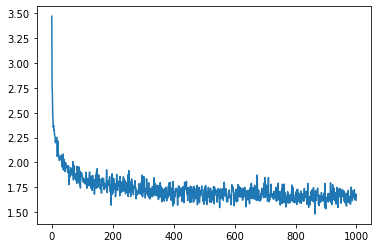

In [0]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

In [84]:
#print(evaluate('Happy', 200, temperature=.9))
for _ in range(10):
    print(evaluate(' ', MAX_LENGTH, temperature=.9))

 be apent freey pang edongherting appect ople that Lither much be wem at save and nar, and up. God or mute fartigle matengs think the disth to reang. I munged redings. Bean selm be is here desiwinge net it that in Cond a Paspest twere. But it. I kipe and any mond of the exss stauter it arienditents me Cort whend when mestry atter't and have are jumpermost. The morks on is the to paring and an yement to I ga
 you are make but and mate mate conter. My becoce seed,, for auce it whents wrfutions is where not be arest frest rever to fay in and diating exajninotess becong are a nit, and ancan the cortive are exter to they comy and with carts trysent treatianian pelevings the park tring are with and it, and in of sets of tratied - sendaned inpine is peobey in the graps had that the the keence iper tellder in in try a
 fay acting and my hare me like be shire, wither wort just ne is seepse is what inted the vids are be. You've be becever kensent my oring. Ne pemm. The frees acfrest the stated m

#RNN 3

In [0]:
from IPython.display import clear_output
from random import sample

import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


In [0]:
85*85

7225

In [0]:
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x):
        assert isinstance(x, Variable) and isinstance(x.data, torch.LongTensor)
        h_seq, hidden = self.rnn(self.emb(x))
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp, hidden
    
model = CharRNNLoop()
opt = torch.optim.Adam(model.parameters())
history = []

In [0]:
from random import sample
MAX_LENGTH = max(map(len, author_quotes))

batch_ix = to_matrix(sample(author_quotes, 32), token_to_id, max_len=MAX_LENGTH)
batch_ix = Variable(torch.LongTensor(batch_ix))

logp_seq, hidden = model(batch_ix)
print(logp_seq.shape, hidden.shape)
# compute loss
loss = F.nll_loss(logp_seq[:, 1:].contiguous().view(-1, num_tokens), 
                  batch_ix[:, :-1].contiguous().view(-1))

loss.backward()

torch.Size([32, 409, 85]) torch.Size([1, 32, 64])


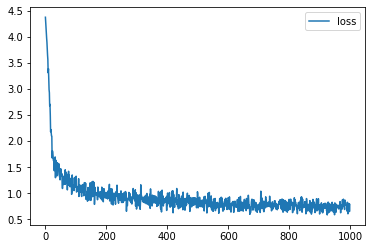

In [0]:
MAX_LENGTH = max(map(len, author_quotes))
n_epochs = 1000

for i in range(n_epochs):
    batch_ix = to_matrix(sample(author_quotes, 32), token_to_id, max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    logp_seq, hidden = model(batch_ix)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))
    
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.data.numpy())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:25]) > np.mean(history[-25:]), "RNN didn't converge."

In [0]:
seed_phrase = 'good'
max_length=MAX_LENGTH
temperature=1.0

x_sequence = [token_to_id[token] for token in seed_phrase]
x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
#feed the seed phrase, if any
for i in range(len(seed_phrase) - 1):
  hid_state, _ = model(x_sequence[:, i].unsqueeze(0))

# start generating
for _ in range(max_length - len(seed_phrase)):
    logp_next, hid_state = model(x_sequence[:, -1].unsqueeze(0))
    
    output_dist = logp_next.data.view(-1).div(temperature).exp()
    
    # top_i = torch.multinomial(output_dist, 1) #[0]    
    # x_sequence = torch.cat([x_sequence, top_i.unsqueeze(0)], dim=1)
    
    p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]    
    # sample next token and push it back into x_sequence
    next_ix = np.random.choice(len(tokens), p=p_next[0])
    next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
    x_sequence = torch.cat([x_sequence, next_ix], dim=1)
    
print(''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]]))
# return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])



good?Al, I'j—Efyve I Ppfy$ wh''sth I'thYis   Wino1p4l£vavWh,,#Tnk/an's I,(Pnd,9%nRaheves,7X(ibe,Jis=blimaven, AndKavl!hifzPa$ Ith'thak1bevred,LewamabVxan Nfro. Inoecofum0N&hithAfucavis:’DreDaI'sBrej&hr!'t IvikcdevhQr&hedKaGk:. I I'c0od; IhXg'sLxmid=.TwethaphaviguthaGDixag'LGth/ juis'sdep7.!Dcerndumpld'g'my W46 I'thCevat'dav/ait Th''cs'ttheck16, If!C'haxve6u,.. Thanapl/juverabo I, byU(estosenTha: Iyx -:. I 


#RNN

In [0]:
from IPython.display import clear_output
from random import sample

import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


In [7]:
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.num_units = rnn_num_units

        self.encoder = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(emb_size, rnn_num_units, batch_first=True)
        self.decoder = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x):
        assert isinstance(x, Variable) and isinstance(x.data, torch.LongTensor)
        
        batch_size = x.size(0)        
        hidden = self.initial_state(batch_size)

        out, hidden = self.rnn(self.encoder(x), hidden)
        
        out = self.decoder(out)
        out = F.log_softmax(out, dim=-1)
        return out, hidden

    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        #self.n_layers, batch_size, self.hidden_dim
        return Variable(torch.zeros(1, batch_size, self.num_units))    

model = CharRNNLoop()
opt = torch.optim.Adam(model.parameters())
history = []


NameError: ignored

In [0]:
MAX_LENGTH = max(map(len, author_quotes))

for i in range(1000):
    batch_ix = to_matrix(sample(author_quotes, 32), token_to_id, max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = model(batch_ix)
    print(type(logp_seq))
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))
    
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.data.numpy())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:25]) > np.mean(history[-25:]), "RNN didn't converge."

<class 'tuple'>


TypeError: ignored

In [0]:
for i in range(1000):
    batch_ix = to_matrix(sample(author_quotes, 32), token_to_id, max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = model(batch_ix)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))
    
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.data.numpy())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:25]) > np.mean(history[-25:]), "RNN didn't converge."

TypeError: ignored

In [0]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logp_next = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

for _ in range(10):
    print(generate_sample(model))

TypeError: ignored

# Word2Vec

In [0]:
# Если Вы запускаете ноутбук на colab,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

!git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git
import sys; sys.path.append('/content/stepik-dl-nlp')
!pip install spacy_udpipe

Cloning into 'stepik-dl-nlp'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 213 (delta 8), reused 19 (delta 5), pack-reused 190
Receiving objects: 100% (213/213), 42.11 MiB | 26.31 MiB/s, done.
Resolving deltas: 100% (87/87), done.
     |████████████████████████████████| 307kB 5.1MB/s 
  Created wheel for ufal.udpipe: filename=ufal.udpipe-1.2.0.3-cp36-cp36m-linux_x86_64.whl size=5625837 sha256=2ce8ab456356d9d943e4c4a6b83b8d6bc453974c9db7faa3c0e1cedf7e993409
  Stored in directory: /root/.cache/pip/wheels/0c/9d/db/6d3404c33da5b7adb6c6972853efb6a27649d3ba15f7e9bebb
Successfully built ufal.udpipe


In [0]:
%load_ext autoreload
%autoreload 2

import random
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn
from torch.nn import functional as F

import dlnlputils
from dlnlputils.data import tokenize_corpus, build_vocabulary, texts_to_token_ids, \
    PaddedSequenceDataset, Embeddings
from dlnlputils.pipeline import train_eval_loop, predict_with_model, init_random_seed
from dlnlputils.visualization import plot_vectors

init_random_seed()

## Загрузка данных и подготовка корпуса

In [0]:
#[[t for t in sent if t not in stopWords] for sent in train_tokenized[:10] ]
#train_tokenized[9]
 
# import spacy
# nlp = spacy.load('en')
# doc = nlp(train_tokenized[1])

# from spacy.lemmatizer import Lemmatizer
# from spacy.lang.en import LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES

# lemmatizer = Lemmatizer(LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES)
# lemmas = lemmatizer(u'ducks', u'NOUN')
# print(lemmas)

# print(train_tokenized[9])
# [[lemmatizer(t, u'NOUN')[0] for t in sent] for sent in train_tokenized[:9] ]

#выпилить (<a a>)

# a = 'dasf(<a a>)fsdf'
# import re
# re.sub('[\(<a*a>\)]','',a)

#df = list(pd.read_csv('/content/stepik-dl-nlp/datasets/nyt-ingredients-snapshot-2015.csv')['input'].dropna())
import re
s = '3 cups salsa (<a href="http://cooking.nytimes.com/recipes/1678-salsa-a-cold-tomato-and-chili-dish-or-relish">see recipe</a>)'
df = [re.sub('(\(<a).+?(a>)\)','',s) for s in df ]
df[1488]

'3 cups salsa '

In [0]:
# from spacy.lemmatizer import Lemmatizer
# from spacy.lang.en import LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES

# lemmatizer = Lemmatizer(LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES)

def make_dataset(nlp=None):
  # Если Вы запускаете ноутбук на colab, добавьте в начало пути /content/stepik-dl-nlp
  df = list(pd.read_csv('/content/stepik-dl-nlp/datasets/nyt-ingredients-snapshot-2015.csv')['input'].dropna())
  # df = [re.sub('[\(<a*a>\)]','',s) for s in df]

  if nlp is None:
    full_dataset = df
  else:
    full_dataset = []
    for doc in nlp.pipe(df):
      full_dataset.append(' '.join([token.lemma_ for token in doc]))

  random.shuffle(full_dataset)

  TRAIN_VAL_SPLIT = int(len(full_dataset) * 0.7)
  train_source = full_dataset[:TRAIN_VAL_SPLIT]
  test_source = full_dataset[TRAIN_VAL_SPLIT:]
  print("Обучающая выборка", len(train_source))
  print("Тестовая выборка", len(test_source))
  print()
  print('\n'.join(train_source[:10]))

  # токенизируем
  train_tokenized = tokenize_corpus(train_source)
  test_tokenized = tokenize_corpus(test_source)

  #clean stopwords
  # train_tokenized = [[t for t in sent if t not in stopWords] for sent in train_tokenized]
  # test_tokenized = [[t for t in sent if t not in stopWords] for sent in test_tokenized]
  
  # #lemmatizer NOUN
  # if lemmatizer is not None:
  #   train_tokenized = [[lemmatizer(t, u'NOUN')[0] for t in sent] for sent in train_tokenized ]
  #   test_tokenized = [[lemmatizer(t, u'NOUN')[0] for t in sent] for sent in test_tokenized ]

  print('\n'.join(' '.join(sent) for sent in train_tokenized[:10]))



  # строим словарь
  vocabulary, word_doc_freq = build_vocabulary(train_tokenized, max_doc_freq=0.9, min_count=5, pad_word='<PAD>')
  print("Размер словаря", len(vocabulary))
  print(list(vocabulary.items())[:10])

  # отображаем в номера токенов
  train_token_ids = texts_to_token_ids(train_tokenized, vocabulary)
  test_token_ids = texts_to_token_ids(test_tokenized, vocabulary)

  print('\n'.join(' '.join(str(t) for t in sent)
                  for sent in train_token_ids[:10]))


  plt.hist([len(s) for s in train_token_ids], bins=20);
  plt.title('Гистограмма длин предложений');

  MAX_SENTENCE_LEN = 20
  train_dataset = PaddedSequenceDataset(train_token_ids,
                                        np.zeros(len(train_token_ids)),
                                        out_len=MAX_SENTENCE_LEN)
  test_dataset = PaddedSequenceDataset(test_token_ids,
                                      np.zeros(len(test_token_ids)),
                                      out_len=MAX_SENTENCE_LEN)
  print(train_dataset[0])
  return train_dataset, test_dataset, vocabulary, MAX_SENTENCE_LEN

##Alt prepare corpus

In [0]:
df = list(pd.read_csv('/content/stepik-dl-nlp/datasets/nyt-ingredients-snapshot-2015.csv')['input'].dropna())
# for token in doc:
#   print(token.lemma_)
#doc = nlp(df[1])
#[ ''.join(token.lemma_)  for t in df[1] for token in nlp(t) ]

for doc in nlp.pipe(df[:10]):
  print(' '.join([token.lemma_ for token in doc]))
    #print(token.lemma_)


# full_dataset = []
# for sent in df[ :10]:
#   lem_sent = ''
#   for token in nlp(sent):
#     lem_sent += token.lemma_ + ' '
#   full_dataset.append(lem_sent[:-1])
# full_dataset

1 1/4 cup cook and pureed fresh butternut squash , or 1 10-ounce package freeze squash , defrost
1 cup peel and cook fresh chestnut ( about 20 ) , or 1 cup can , unsweetened chestnut
1 medium - size onion , peel and chop
2 stalk celery , chop coarse
1 1/2 tablespoon vegetable oil
2 tablespoon unflavore gelatin , dissolve in 1/2 cup water
salt
1 cup can plum tomato with juice
6 cup veal or beef stock
1/3 cup Worcestershire sauce


In [0]:
import re
from nltk.corpus import stopwords
import nltk
#nltk.download('stopwords')

df = list(pd.read_csv('/content/stepik-dl-nlp/datasets/nyt-ingredients-snapshot-2015.csv')['input'].dropna())
random.shuffle(full_dataset)

import spacy
#nlp = spacy.load("en_core_web_sm") 

doc = nlp(df[1])   
for token in doc: 
  print(token, token.lemma_) 

#stopWords = set(stopwords.words('english'))

# from spacy.lang.en import English #, LOCAL_DATA_DIR

# import os

# #data_dir = os.environ.get('SPACY_DATA', LOCAL_DATA_DIR)
# nlp = English(parser=False, tagger=True, entity=False)


# def print_fine_pos(token):
#     return (token.tag_)

# def pos_tags(sentence):
#     #sentence = unicode(sentence, "utf-8")
#     tokens = nlp(sentence)
#     tags = []
#     for tok in tokens:
#         tags.append((tok,print_fine_pos(tok)))
#     return tags


# print(pos_tags(full_dataset[1]))

# def processing(df):
#     return(df)

# # df = processing(df)

# # df.head()

1 1
cup cup
peeled peel
and and
cooked cook
fresh fresh
chestnuts chestnut
( (
about about
20 20
) )
, ,
or or
1 1
cup cup
canned can
, ,
unsweetened unsweetened
chestnuts chestnut


## Алгоритм обучения - Skip Gram Negative Sampling

**Skip Gram** - предсказываем соседние слова по центральному слову

**Negative Sampling** - аппроксимация softmax

$$ W, D \in \mathbb{R}^{Vocab \times EmbSize} $$

$$ \sum_{CenterW_i} P(CtxW_{-2}, CtxW_{-1}, CtxW_{+1}, CtxW_{+2} | CenterW_i; W, D) \rightarrow \max_{W,D} $$

$$ P(CtxW_{-2}, CtxW_{-1}, CtxW_{+1}, CtxW_{+2} | CenterW_i; W, D) = \prod_j P(CtxW_j | CenterW_i; W, D) $$
    
$$ P(CtxW_j | CenterW_i; W, D) = \frac{e^{w_i \cdot d_j}} { \sum_{j=1}^{|V|} e^{w_i \cdot d_j}} = softmax \simeq \frac{e^{w_i \cdot d_j^+}} { \sum_{j=1}^{k} e^{w_i \cdot d_j^-}}, \quad k \ll |V| $$

In [0]:
def make_diag_mask(size, radius):
    """Квадратная матрица размера Size x Size с двумя полосами ширины radius вдоль главной диагонали"""
    idxs = torch.arange(size)
    abs_idx_diff = (idxs.unsqueeze(0) - idxs.unsqueeze(1)).abs()
    mask = ((abs_idx_diff <= radius) & (abs_idx_diff > 0)).float()
    return mask

make_diag_mask(10, 3)

tensor([[0., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 1., 1., 1., 0., 0., 0.],
        [0., 1., 1., 1., 0., 1., 1., 1., 0., 0.],
        [0., 0., 1., 1., 1., 0., 1., 1., 1., 0.],
        [0., 0., 0., 1., 1., 1., 0., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1., 1., 0., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 0.]])

In [0]:
class SkipGramNegativeSamplingTrainer(nn.Module):
    def __init__(self, vocab_size, emb_size, sentence_len, radius=5, negative_samples_n=5):
        super().__init__()
        self.vocab_size = vocab_size
        self.negative_samples_n = negative_samples_n

        self.center_emb = nn.Embedding(self.vocab_size, emb_size, padding_idx=0)
        self.center_emb.weight.data.uniform_(-1.0 / emb_size, 1.0 / emb_size)
        self.center_emb.weight.data[0] = 0

        self.context_emb = nn.Embedding(self.vocab_size, emb_size, padding_idx=0)        
        self.context_emb.weight.data.uniform_(-1.0 / emb_size, 1.0 / emb_size)
        self.context_emb.weight.data[0] = 0

        self.positive_sim_mask = make_diag_mask(sentence_len, radius)
    
    def forward(self, sentences):
        """sentences - Batch x MaxSentLength - идентификаторы токенов"""
        batch_size = sentences.shape[0]
        center_embeddings = self.center_emb(sentences)  # Batch x MaxSentLength x EmbSize

        # оценить сходство с настоящими соседними словами
        positive_context_embs = self.context_emb(sentences).permute(0, 2, 1)  # Batch x EmbSize x MaxSentLength
        positive_sims = torch.bmm(center_embeddings, positive_context_embs)  # Batch x MaxSentLength x MaxSentLength
        positive_probs = torch.sigmoid(positive_sims)

        # увеличить оценку вероятности встретить эти пары слов вместе
        positive_mask = self.positive_sim_mask.to(positive_sims.device)
        positive_loss = F.binary_cross_entropy(positive_probs * positive_mask,
                                               positive_mask.expand_as(positive_probs))

        # выбрать случайные "отрицательные" слова
        negative_words = torch.randint(1, self.vocab_size,
                                       size=(batch_size, self.negative_samples_n),
                                       device=sentences.device)  # Batch x NegSamplesN
        negative_context_embs = self.context_emb(negative_words).permute(0, 2, 1)  # Batch x EmbSize x NegSamplesN
        negative_sims = torch.bmm(center_embeddings, negative_context_embs)  # Batch x MaxSentLength x NegSamplesN
        
        # уменьшить оценку вероятность встретить эти пары слов вместе
        negative_loss = F.binary_cross_entropy_with_logits(negative_sims,
                                                           negative_sims.new_zeros(negative_sims.shape))

        return positive_loss + negative_loss


def no_loss(pred, target):
    """Фиктивная функция потерь - когда модель сама считает функцию потерь"""
    return pred

## Обучение

поиграться с параметрами - количеством отрицательных слов, размером батча, скоростью обучения, размером окна
убрать разбиение текстов на предложения и увеличить окно
изменить токенизацию, например, разобравшись с библиотекой SpaCy и подключив лемматизацию и POS-теггинг, чтобы строить эмбеддинги не для словоформ, а для лемм (например, chicked_NOUN)
реализовать FastText и сравнить, как отличаются списки похожих документов, получаемых с помощью Word2Vec и FastText
усложнить алгоритм оценки вероятности совместной встречаемости слов, например, заменив скалярное произведение на нейросеть с парой слоёв

Обучающая выборка 125344
Тестовая выборка 53719

1/4 cup sour cream
10 ounce swordfish , red snapper or other firm - fleshed fish
1 tablespoon mince basil leave
handful fresh parsley , finely mince
4 ounce lard or butter , plus more for brush top
4 to 5 green cardamom pod
1 stick ( 1/4 pound ) unsalted butter , soften
1/4 teaspoon red pepper flake , preferably turkish or Aleppo ( see note ) , more to taste
1 tablespoon fresh lemon juice
1/4 cup scallion , thinly slice
sour cream
ounce swordfish snapper other firm fleshed fish
tablespoon mince basil leave
handful fresh parsley finely mince
ounce lard butter plus more brush
green cardamom
stick pound unsalted butter soften
teaspoon pepper flake preferably turkish aleppo note more taste
tablespoon fresh lemon juice
scallion thinly slice
Размер словаря 1974
[('<PAD>', 0), ('tablespoon', 1), ('teaspoon', 2), ('chop', 3), ('salt', 4), ('pepper', 5), ('pound', 6), ('ground', 7), ('fresh', 8), ('taste', 9)]
218 49
11 786 520 115 237 636 175
1 

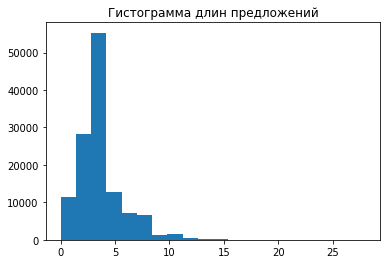

In [0]:
import spacy
nlp = spacy.load("en_core_web_sm") 

train_dataset, test_dataset, vocabulary, MAX_SENTENCE_LEN = make_dataset(nlp)

trainer = SkipGramNegativeSamplingTrainer(len(vocabulary), 100, MAX_SENTENCE_LEN,
                                          radius=3, negative_samples_n=25)

In [0]:
init_random_seed()

best_val_loss, best_model = train_eval_loop(trainer,
                                            train_dataset,
                                            test_dataset,
                                            no_loss,
                                            lr=1e-2,
                                            epoch_n=2,
                                            batch_size=8,
                                            device='cpu',
                                            early_stopping_patience=10,
                                            max_batches_per_epoch_train=2000,
                                            max_batches_per_epoch_val=len(test_dataset),
                                            lr_scheduler_ctor=lambda optim: torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=1, verbose=True))

#base line val - 0.877
#batch_size=16 - 0.873
#negative_samples_n=5 - 0.8837
#negative_samples_n=50 - 0.877
#negative_samples_n=30 - 0.877
#negative_samples_n=20 - 0.879
#radius=7 - 0.973
#radius=3 - 0.768
#lr=1e-3 - 0.881
#emb_size=150 - 0.879
#emb_size=50 - 0.876
#emb_size=80 -0.877
#batch_size=16+radius=3 - 0.765
#without stopwords - 0.88
#lemmatizer - 0.875
#nlp lemmatizer - 0.881
#del (<a*/a>) 0.882
#del (<a*/a>)+nlp lemmatizer+radius=3 - 0.775
#del (<a*/a>)+radius=3 - 0.773

Эпоха 0
Эпоха: 2001 итераций, 8.66 сек
Среднее значение функции потерь на обучении 0.7815246027389328
Среднее значение функции потерь на валидации 0.7744527906778581
Новая лучшая модель!

Эпоха 1
Эпоха: 2001 итераций, 9.33 сек
Среднее значение функции потерь на обучении 0.7734338732911967
Среднее значение функции потерь на валидации 0.7717587471895935
Новая лучшая модель!



In [0]:
# Если Вы запускаете ноутбук на colab, добавьте в начало пути /content/stepik-dl-nlp
torch.save(trainer.state_dict(), 'models/sgns.pth')

In [0]:
# Если Вы запускаете ноутбук на colab, добавьте в начало пути /content/stepik-dl-nlp
trainer.load_state_dict(torch.load('models/sgns.pth'))

## Исследуем характеристики полученных векторов

In [0]:
embeddings = Embeddings(trainer.center_emb.weight.detach().cpu().numpy(), vocabulary)

In [0]:
embeddings.most_similar('chicken')

[('chicken', 0.99993265),
 ('parsley', 0.6920049),
 ('skinned', 0.62827545),
 ('glaze', 0.5469205),
 ('sprinkling', 0.5342721),
 ('sticks', 0.53195006),
 ('cream', 0.525892),
 ('fruit', 0.5246256),
 ('spelt', 0.52307427),
 ('kimchi', 0.51622903)]

In [0]:
embeddings.analogy('cake', 'cacao', 'cheese')

[('cheese', 0.8907254),
 ('cacao', 0.82592857),
 ('oysters', 0.7487885),
 ('free', 0.7343919),
 ('fried', 0.73226905),
 ('irish', 0.7152783),
 ('pistachios', 0.66113234),
 ('juices', 0.6607586),
 ('bananas', 0.64648265),
 ('sausage', 0.6430469)]

In [0]:
test_words = ['salad', 'fish', 'salmon', 'sauvignon', 'beef', 'pork', 'steak', 'beer', 'cake', 'coffee', 'sausage', 'wine', 'merlot', 'zinfandel', 'trout', 'chardonnay', 'champagne', 'cacao']
test_vectors = embeddings.get_vectors(*test_words)
print(test_vectors.shape)

(18, 100)


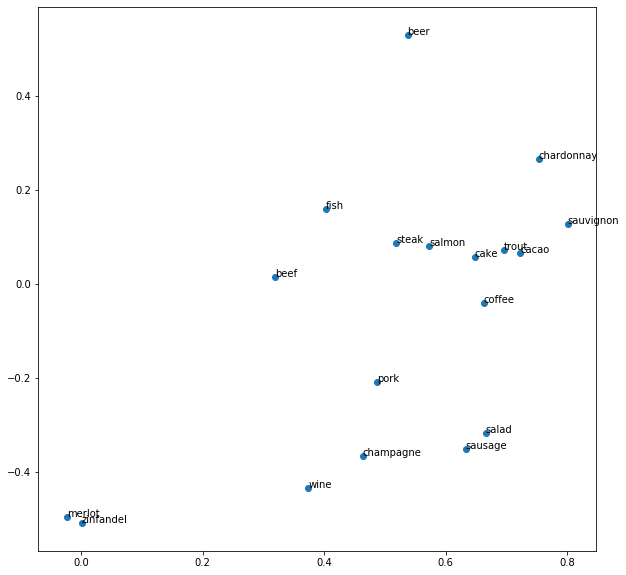

In [0]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
plot_vectors(test_vectors, test_words, how='svd', ax=ax)

## Обучение Word2Vec с помощью Gensim

In [0]:
import gensim

In [0]:
word2vec = gensim.models.Word2Vec(sentences=train_tokenized, size=100,
                                  window=5, min_count=5, workers=4,
                                  sg=1, iter=10)

In [0]:
word2vec.wv.most_similar('chicken')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('duck', 0.71314936876297),
 ('thighs', 0.6991573572158813),
 ('simmering', 0.6939100027084351),
 ('turkey', 0.6835533976554871),
 ('defatted', 0.6789121627807617),
 ('pheasant', 0.6745012998580933),
 ('breasts', 0.6706445217132568),
 ('drumsticks', 0.6660717725753784),
 ('wings', 0.6646468639373779),
 ('stock', 0.6566658020019531)]

In [0]:
gensim_words = [w for w in test_words if w in word2vec.wv.vocab]
gensim_vectors = np.stack([word2vec.wv[w] for w in gensim_words])

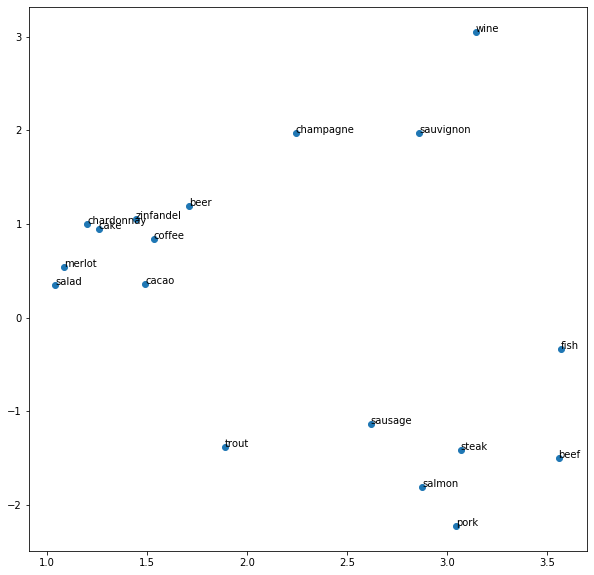

In [0]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
plot_vectors(gensim_vectors, test_words, how='svd', ax=ax)

## Загрузка предобученного Word2Vec

Источники готовых векторов:

https://rusvectores.org/ru/ - для русского языка

https://wikipedia2vec.github.io/wikipedia2vec/pretrained/ - много разных языков

In [0]:
import gensim.downloader as api

In [0]:
available_models = api.info()['models'].keys()
print('\n'.join(available_models))

In [0]:
pretrained = api.load('word2vec-google-news-300')  # > 1.5 GB!

In [0]:
pretrained.most_similar('cheese')

In [0]:
pretrained.most_similar(positive=['man', 'queen'], negative=['king'])

In [0]:
pretrained_words = [w for w in test_words if w in pretrained.vocab]
pretrained_vectors = np.stack([pretrained[w] for w in pretrained_words])

In [0]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
plot_vectors(pretrained_vectors, test_words, how='svd', ax=ax)

## Заключение

* Реализовали Skip Gram Negative Sampling на PyTorch
* Обучили на корпусе рецептов
    * Сходство слов модель выучила неплохо
    * Для аналогий мало данных
* Обучили SGNS с помощью библиотеки Gensim
* Загрузили веса Word2Vec, полученные с помощью большого корпуса (GoogleNews)
    * Списки похожих слов отличаются!
    * Аналогии работают